In [1]:
#1) Create a summary table of more scenarios
#2) Create a summary of the summary table
! pip install geopandas
! pip install pandas
! pip install pygeos
! pip install boto
! pip install s3fs
! pip install shapely
! pip install gcsfs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import time
from itertools import groupby
import geopandas as gpd

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_1718037/487853300.py:16: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).

In [2]:
def collectAllData(outDirectory, year_it,
                  trips, activities, PTs, PtoPTs, LT, PLT, VLT, ST, name):

    
    
    if is_GEO:
        BGs = gpd.read_file('local_files/641aa0d4-ce5b-4a81-9c30-8790c4ab8cfb202047-1-wkkklf.j5ouj.shp')
        trips = addGeometryIdToDataFrame(trips, BGs, 'originX', 'originY', 'startBlockGroup')
        trips = addGeometryIdToDataFrame(trips, BGs, 'destinationX', 'destinationY', 'endBlockGroup')
        activities = addGeometryIdToDataFrame(activities, BGs, 'activityLocationX', 'activityLocationY', 'activityBlockGroup')
        
        print('Add block ID infos')
        block_info = pd.read_csv('local_files/bg_w_geog_labels.csv')
        trips['startBlockGroup'] = trips['startBlockGroup'].fillna(0).astype(int)
        trips['endBlockGroup'] = trips['endBlockGroup'].fillna(0).astype(int)
        activities['activityBlockGroup'] = activities['activityBlockGroup'].fillna(0).astype(int)
        PTs['startBlockGroup'] = PTs['startBlockGroup'].fillna(0).astype(int)
        PTs['endBlockGroup'] = PTs['endBlockGroup'].fillna(0).astype(int)
        PtoPTs['startBlockGroup'] = PtoPTs['startBlockGroup'].fillna(0).astype(int)
        PtoPTs['endBlockGroup'] = PtoPTs['endBlockGroup'].fillna(0).astype(int)
        if is_LT:
            LT['BlockGroup'] = LT['BlockGroup'].fillna(0).astype(int)
            PLT['BlockGroup'] = PLT['BlockGroup'].fillna(0).astype(int)
            VLT['BlockGroup'] = VLT['BlockGroup'].fillna(0).astype(int)
        
        trips = pd.merge(trips, block_info,  how='left',  left_on = 'startBlockGroup',right_on = 'bgid')
        trips = pd.merge(trips, block_info,  how='left',  left_on = 'endBlockGroup',right_on = 'bgid',suffixes = ['_start','_end'])
        activities = pd.merge(activities, block_info,  how='left',  left_on = 'activityBlockGroup',right_on = 'bgid',)
        PTs = pd.merge(PTs, block_info,  how='left',  left_on = 'startBlockGroup',right_on = 'bgid',)
        PTs = pd.merge(PTs, block_info,  how='left',  left_on = 'endBlockGroup',right_on = 'bgid',suffixes = ['_start','_end'])
        PtoPTs = pd.merge(PtoPTs, block_info,  how='left',  left_on = 'startBlockGroup',right_on = 'bgid',)
        PtoPTs = pd.merge(PtoPTs, block_info,  how='left',  left_on = 'endBlockGroup',right_on = 'bgid',suffixes = ['_start','_end'])
        if is_LT:
            LT = pd.merge(LT, block_info,  how='left',  left_on = 'BlockGroup',right_on = 'bgid',)
            PLT = pd.merge(PLT, block_info,  how='left',  left_on = 'BlockGroup',right_on = 'bgid',)
            VLT = pd.merge(VLT, block_info,  how='left',  left_on = 'BlockGroup',right_on = 'bgid',)

    # PTs = addGeometryIdToDataFrame(PTs, BGs, 'startX', 'startY', 'startBlockGroup')
    # PTs = addGeometryIdToDataFrame(PTs, BGs, 'endX', 'endY', 'endBlockGroup')
    PTs.index.set_names('PathTraversalID', inplace=True)
    
    
    print('writing results on', outDirectory+ 'postprocessOutputs/'+year_it)

    trips.to_csv(outDirectory+ 'postprocessOutputs/'+year_it+'/trips.csv.gz', index=True)
    PTs.to_csv(outDirectory+ 'postprocessOutputs/'+year_it+'/vehicles.csv.gz', index=True)
    activities.to_csv(outDirectory+ 'postprocessOutputs/'+year_it+'/activities.csv.gz', index=True)
    PtoPTs.to_csv(outDirectory+ 'postprocessOutputs/'+year_it+'/personToVehicles.csv.gz', index=True)
    if is_LT:
        LT.to_csv(outDirectory+ 'postprocessOutputs/'+year_it+'/linkTable.csv.gz', index=True)
        PLT.to_csv(outDirectory+ 'postprocessOutputs/'+year_it+'/personLinkTable.csv.gz', index=True)
        VLT.to_csv(outDirectory+ 'postprocessOutputs/'+year_it+'/vehicleLinkTable.csv.gz', index=True) 
    ST.to_csv(outDirectory+ 'postprocessOutputs/'+year_it+'/summaryTable.csv.gz', index=True)
    
    if is_plot:
        plot_and_save_figures(outDirectory+ 'postprocessOutputs/'+year_it+'/figures/', ST, name)
    

In [3]:
def plot_and_save_figures(fp, ST, name, mins, mults):
    
    colors_std = ['#FF7E72', 
            '#FFAC91',
            '#FFC9B9',
            '#5DC7B6', 
    #         '#79DFCE',
            '#8CD7FF',
            '#69ADF1']

    x_vlines = [ #9.5#6.5,10.5, 16.5, 22.5 , 28.5,34.5 #4.5,
    #             7.5,11.5,15.5,19.5,23.5
               ]
    
    VMT_plot(ST, name, fp, colors_std, x_vlines, Scale, mins[0], mults[0])
    VHT_plot(ST, name, fp, colors_std, x_vlines, Scale, mins[1], mults[1])
    speed_plot(ST, name, fp, colors_std, x_vlines, Scale, mins[2], mults[2])
    energy_plot(ST, name, fp, colors_std, x_vlines, Scale, mins[3], mults[3])
    modesplit_plot(ST, name, fp, colors_std, x_vlines, Scale, mins[4], mults[4])
    PMT_mode_plot(ST, name, fp, colors_std, x_vlines, Scale, mins[5], mults[5])
    VMT_fuel_plot(ST, name, fp, colors_std, x_vlines, Scale, mins[6], mults[6])
    PMT_vehicle_plot(ST, name, fp, colors_std, x_vlines, Scale, mins[7], mults[7])
    PHT_vehicle_plot(ST, name, fp, colors_std, x_vlines, Scale, mins[8], mults[8])

    

In [4]:
def plot(colors,# list of colors to be used (longer as the labels, or more)
         values,# matrix with -length of labels- rows per -number of scenarios- colums
         labels,# labels for the legend
         filepath_res,# where to save the figures
         name_fig,# name of the figure
         ylabel,# label of y ax
         x_vlines,#list of vlines coordinates
         min_y,# minimum y value
         max_y,# maximum y value
         labelScenarios,# name of scenarios
         is_top_labels,# print the total value and variation with baselina at the top of the column,
         title
        ):

    current_bottom = np.zeros((len(labelScenarios)))+10.0

    fig, (ax,ax0) = plt.subplots(2,1,sharex=True,gridspec_kw={'height_ratios':[10, 0.5]},
                    figsize=(np.max([2*len(labelScenarios),8]), 8))
    
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0, 
                        hspace=0.05)
    first = 1
    for row, key, color in zip(values, labels, colors):
        if first == 1:
            p0 = ax0.bar(labelScenarios, np.ones((len(labelScenarios))), color = color)
            if np.sum(row)>0:
                p1 = ax.bar(labelScenarios, row-10.0, color = color, bottom = current_bottom, label = key)
                fir = 1
                _labels=[]
                for y,t in zip(row, row/row[0]*100-100):
                    if fir ==1:
                        _labels.append('%.2f'%(y))
                    else:
                        if t>0:
                            _labels.append('%.2f'%(y))
                        else:
                            _labels.append('%.2f'%(y))
                    fir = 0

                ax0.bar_label(p0,labels = _labels , label_type='center', fontsize=12.5)
            current_bottom+=row-10.0
        else:
            if np.sum(row)>0:
                p1 = ax.bar(labelScenarios, row, color = color, bottom = current_bottom, label = key)
                fir = 1
                _labels=[]
                for y,t in zip(row, row/row[0]*100-100):
                    if fir ==1:
                        _labels.append('%.2f'%(y))
                    else:
                        if t>0:
                            _labels.append('%.2f'%(y))
                        else:
                            _labels.append('%.2f'%(y))
                    fir = 0

                ax.bar_label(p1,labels = _labels , label_type='center', fontsize=12.5)
            current_bottom+=row
        first = 0

    fir =1
    __labels = []
    tot_bas =np.sum(values[:,0])
    for row in values.transpose():
        if fir == 1:
            __labels.append('%.2f'%(np.sum(row)))
        else:
            t =np.sum(row)/tot_bas*100.0-100.
            if t>0:
                __labels.append('%.2f \n (+%.2f%%)'%(np.sum(row),t),)
            else:
                __labels.append('%.2f \n (%.2f%%)'%(np.sum(row),t), )
        fir = 0
    if is_top_labels:
        ax.bar_label(p1,labels = __labels, padding = 3, fontsize=12.5 )

    ax.set_ylim([min_y,max_y])
    ax.set_ylabel(ylabel, fontsize=12.5)
    y_labels = ax.get_yticks()
    ax.vlines(x=x_vlines, ymin=9, ymax=max_y, color='k',alpha = 0.4)
    ax.set_yticklabels(['%i'%(y) for y in y_labels], fontsize=12.5)
    ax.legend(loc = 9, ncol = 9, fontsize=9.8)
    ax.set_title(title)
    ax.grid(axis='y')
    ax0.set_ylim(0,1)
    ax0.set_yticklabels([0], fontsize=12.5)
    ax0.set_xticklabels(labelScenarios, fontsize=12.5, rotation = 10)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='x',which='both',bottom=False)
    ax0.spines['top'].set_visible(False)
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
    d = .005  
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)      
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)
    kwargs.update(transform=ax0.transAxes)  
    ax0.plot((-d, +d), (1 - d*20, 1 + d*20), **kwargs)  
    ax0.plot((1 - d, 1 + d), (1 - d*20, 1 + d*20), **kwargs)
    ax.hlines(y = min_y,xmin = -0.5, xmax = len(labelScenarios) - 0.5,color = 'k', linestyle = ':',linewidth = 2.5)
    ax0.hlines(y = 1, xmin = -0.5, xmax = len(labelScenarios) - 0.5,color = 'k', linestyle = ':',linewidth = 2.5)
    ax0.vlines(x=x_vlines, ymin=0, ymax=1, color='k',alpha = 0.4)
    plt.savefig(filepath_res + name_fig)

In [5]:
def plot2(colors,# list of colors to be used (longer as the labels, or more)
         values,# matrix with -length of labels- rows per -number of scenarios- colums
         labels,# labels for the legend
         filepath_res,# where to save the figures
         name_fig,# name of the figure
         ylabel,# label of y ax
#          x_vlines,#list of vlines coordinates
         min_y,# minimum y value
         max_y,# maximum y value
         labelScenarios,# name of scenarios
         is_top_labels,# print the total value and variation with baselina at the top of the column
          title
        ):

    current_bottom = np.zeros((len(labelScenarios)))

    fig, (ax) = plt.subplots(1,1,sharex=True,
                    figsize=(np.max([2*len(labelScenarios),8]), 8))
    
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0, 
                        hspace=0.05)
    for row, key, color in zip(values, labels, colors):

        if np.sum(row)>0:
            p1 = ax.bar(labelScenarios, row, color = color, bottom = current_bottom, label = key)
            fir = 1
            _labels=[]
            for y,t in zip(row, row/row[0]*100-100):
                if fir ==1:
                    _labels.append('%.2f'%(y))
                else:
                    if t>0:
                        _labels.append('%.2f'%(y))
                    else:
                        _labels.append('%.2f'%(y))
                fir = 0

            ax.bar_label(p1,labels = _labels , label_type='center', fontsize=12.5)
        current_bottom+=row

    fir =1
    __labels = []
    tot_bas =np.sum(values[:,0])
    for row in values.transpose():
        if fir == 1:
            __labels.append('%.2f'%(np.sum(row)))
        else:
            t =np.sum(row)/tot_bas*100.0-100.
            if t>0:
                __labels.append('%.2f \n (+%.2f%%)'%(np.sum(row),t),)
            else:
                __labels.append('%.2f \n (%.2f%%)'%(np.sum(row),t), )
        fir = 0
    if is_top_labels:
        ax.bar_label(p1,labels = __labels, padding = 3, fontsize=12.5 )

    ax.set_ylim([min_y,max_y])
    ax.set_ylabel(ylabel, fontsize=12.5)
    y_labels = ax.get_yticks()
#     ax.vlines(x=x_vlines, ymin=0, ymax=max_y, color='k',alpha = 0.4)
    ax.set_yticklabels(['%i'%(y) for y in y_labels], fontsize=12.5)
    ax.legend(loc = 9, ncol = 9, fontsize=9.8)
    ax.set_title(title)
    ax.grid(axis='y')
#     ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='x',which='both',bottom=False)
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
#     d = .005  
#     kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
#     ax.plot((-d, +d), (-d, +d), **kwargs)      
#     ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)


    plt.savefig(filepath_res + name_fig)

In [6]:
def plot3(colors,# list of colors to be used (longer as the labels, or more)
         values,# matrix with -length of labels- rows per -number of scenarios- colums
         labels,# labels for the legend
         filepath_res,# where to save the figures
         name_fig,# name of the figure
         ylabel,# label of y ax
#          x_vlines,#list of vlines coordinates
         min_y,# minimum y value
         max_y,# maximum y value
         labelScenarios,# name of scenarios
         is_top_labels,# print the total value and variation with baselina at the top of the column
          title
        ):

#     current_bottom = np.zeros((len(labelScenarios)))

    fig, (ax) = plt.subplots(1,1,sharex=True,
                    figsize=(np.max([2*len(labelScenarios),8]), 8))
    
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0, 
                        hspace=0.05)
    for row, key, color in zip(values, labels, colors):

        if np.sum(row)>0:
            p1 = ax.plot(labelScenarios, row, 'o-', color = color, 
#                         bottom = current_bottom, 
                        label = key,
                        linewidth=3.7,
                        )
            fir = 1
            _labels=[]
            for y,t in zip(row, row/row[0]*100-100):
                if fir ==1:
                    _labels.append('%.2f'%(y))
                else:
                    if t>0:
                        _labels.append('%.2f'%(y))
                    else:
                        _labels.append('%.2f'%(y))
                fir = 0

#             ax.bar_label(p1,labels = _labels , label_type='center', fontsize=12.5)
#         current_bottom+=row

    fir =1
    __labels = []
    tot_bas =np.sum(values[:,0])
    for row in values.transpose():
        if fir == 1:
            __labels.append('%.2f'%(np.sum(row)))
        else:
            t =np.sum(row)/tot_bas*100.0-100.
            if t>0:
                __labels.append('%.2f \n (+%.2f%%)'%(np.sum(row),t),)
            else:
                __labels.append('%.2f \n (%.2f%%)'%(np.sum(row),t), )
        fir = 0
#     if is_top_labels:
#         ax.bar_label(p1,labels = __labels, padding = 3, fontsize=12.5 )

    ax.set_ylim([min_y,max_y])
    ax.set_ylabel(ylabel, fontsize=12.5)
    y_labels = ax.get_yticks()
#     ax.vlines(x=x_vlines, ymin=0, ymax=max_y, color='k',alpha = 0.4)
    ax.set_yticklabels(['%i'%(y) for y in y_labels], fontsize=12.5)
    ax.legend(loc = 9, ncol = 9, fontsize=9.8)
    ax.set_title(title)
    ax.grid(axis='y')
    ax.grid(axis='x')

#     ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='x',which='both',bottom=False)
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
#     d = .005  
#     kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
#     ax.plot((-d, +d), (-d, +d), **kwargs)      
#     ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)


    plt.savefig(filepath_res + name_fig)

In [7]:
#VMT
def VMT_plot(summarytable, nameScenarios, filepath_res, colors_std, x_vlines, Scale, minim, multi):
    print('VMT plot')
    RH_feature1 = ['Length Vehicle SUM Ride Hail [km]']
    RH_feature2 = ['Length Vehicle SUM Empty Ride Hail [km]']
    RH_label = 'Ride Hail Empty'
    colors = colors_std

    if is_WC:
        RH_feature1 = ['Length Vehicle SUM Empty Ride Hail [km]']+['Length Vehicle SUM Ride Hail [km]']
        RH_feature2 = ['Length Vehicle SUM Empty Ride Hail WC [km]']+['Length Vehicle SUM Ride Hail WC [km]']
        RH_label = 'Ride Hail WC'
        colors = ['#FF7E72', 
            '#FFAC91',
            '#d19f9f',
            '#5DC7B6', 
    #         '#79DFCE',
            '#8CD7FF',
            '#69ADF1']

    name_fig = 'VMT-mode.png'
    rows_VMT = [['Length Vehicle SUM Car [km]',
                    'Length Vehicle SUM Car HOV2 [km]',
                    'Length Vehicle SUM Car HOV3 [km]',
                    'Length Vehicle SUM CAV [km]'
                    ],RH_feature1
                ,RH_feature2,
                ['Length Vehicle SUM Bus [km]',
                    'Length Vehicle SUM Tram [km]',
                    'Length Vehicle SUM Rail [km]',
                    'Length Vehicle SUM Subway [km]',
                    'Length Vehicle SUM Cable Car [km]',
                    'Length Vehicle SUM Ferry [km]',
                    'Length Vehicle SUM Empty Bus [km]',
                    'Length Vehicle SUM Empty Tram [km]',
                    'Length Vehicle SUM Empty Subway [km]',
                    'Length Vehicle SUM Empty Cable Car [km]',
                    'Length Vehicle SUM Empty Ferry [km]',
                    'Length Vehicle SUM Empty Rail [km]']
                ]
    labels = ['Personal Vehicle', 'Ride Hail ', RH_label, 'Transit' ]
    title = 'Vehicle Miles Traveled, by Vehicle Type (10E+6) - Differences with the Baseline Scenario'
    ylabel = 'Vehicle Miles Traveled, by Vehicle Type (10E+6)'
    values = np.zeros((len(rows_VMT),len(nameScenarios)))

    for scenario, i in zip(nameScenarios, range(len(nameScenarios))):
        for attributes, j in zip(rows_VMT, range(len(rows_VMT))):
            for attribute in attributes:
                values[j,i] += float(summarytable.at[attribute, scenario])/1000000*0.621371
    print(values)
    values = np.nan_to_num(values)
    values = values/Scale
    min_y = minim*Scale
    max_y = np.sum(values[:,0])*multi
    print(min_y,max_y, values)
    is_top_labels = True
    plot(colors, values, labels, filepath_res, name_fig, ylabel, x_vlines, min_y, max_y, nameScenarios, is_top_labels, title)


In [8]:
#VHT
def VHT_plot(summarytable, nameScenarios, filepath_res, colors_std, x_vlines, Scale, minim, multi):
    print('VHT plot')

    RH_feature1 = ['Duration Vehicle SUM Ride Hail [h]']
    RH_feature2 = ['Duration Vehicle SUM Empty Ride Hail [h]']
    RH_label = 'Ride Hail Empty'
    colors = colors_std
    if is_WC:
        RH_feature1 = ['Duration Vehicle SUM Empty Ride Hail [h]']+['Duration Vehicle SUM Ride Hail [h]']
        RH_feature2 = ['Duration Vehicle SUM Empty Ride Hail WC [h]']+['Duration Vehicle SUM Ride Hail WC [h]']
        RH_label = 'Ride Hail WC'
        colors = ['#FF7E72', 
            '#FFAC91',
            '#d19f9f',
            '#5DC7B6', 
    #         '#79DFCE',
            '#8CD7FF',
            '#69ADF1']

    name_fig = 'VHT_mode.png'
    rows_VMT = [['Duration Vehicle SUM Car [h]',
                    'Duration Vehicle SUM Car HOV2 [h]',
                    'Duration Vehicle SUM Car HOV3 [h]',
                    'Duration Vehicle SUM CAV [h]'
                    ],RH_feature1
                ,RH_feature2,
                ['Duration Vehicle SUM Bus [h]',
                    'Duration Vehicle SUM Tram [h]',
                    'Duration Vehicle SUM Rail [h]',
                    'Duration Vehicle SUM Subway [h]',
                    'Duration Vehicle SUM Cable Car [h]',
                    'Duration Vehicle SUM Ferry [h]',
                    'Duration Vehicle SUM Empty Bus [h]',
                    'Duration Vehicle SUM Empty Tram [h]',
                    'Duration Vehicle SUM Empty Subway [h]',
                    'Duration Vehicle SUM Empty Cable Car [h]',
                    'Duration Vehicle SUM Empty Ferry [h]',
                    'Duration Vehicle SUM Empty Rail [h]']
                ]
    labels = ['Personal Vehicle', 'Ride Hail ', RH_label, 'Transit', ]
    title = 'Vehicle Hours Traveled, by Vehicle Type (10E+3) - Differences with the Baseline Scenario'
    ylabel = 'Vehicle Hours Traveled, by Vehicle Type (10E+3)'
    values = np.zeros((len(rows_VMT),len(nameScenarios)))

    for scenario, i in zip(nameScenarios, range(len(nameScenarios))):
        for attributes, j in zip(rows_VMT, range(len(rows_VMT))):
            for attribute in attributes:
                values[j,i] += float(summarytable.at[attribute, scenario])/1000
    print(values)

    values = np.nan_to_num(values)
    values = values/Scale

    min_y = minim*Scale
    max_y = np.sum(values[:,0])*multi
    is_top_labels = True

    plot(colors, values, labels, filepath_res, name_fig, ylabel, x_vlines, min_y, max_y, nameScenarios, is_top_labels, title)


In [9]:
#Speed
def speed_plot(summarytable, nameScenarios, filepath_res, colors_std, x_vlines, Scale, minim, multi):
    print('Speed plot')

    name_fig = 'Speeds_mode.png'
    RH_feature1 = ['Length Vehicle SUM Ride Hail [km]']
    RH_feature2 = ['Length Vehicle SUM Empty Ride Hail [km]']
    RH_label = 'Ride Hail Empty'
    colors = colors_std

    if is_WC:
        RH_feature1 = ['Length Vehicle SUM Ride Hail WC [km]']+['Length Vehicle SUM Ride Hail [km]']
        RH_feature2 = ['Length Vehicle SUM Empty Ride Hail WC [km]']+['Length Vehicle SUM Empty Ride Hail [km]']
        RH_label = 'Ride Hail WC'
        colors = ['#FF7E72', 
            '#FFAC91',
            '#d19f9f',
            '#5DC7B6', 
    #         '#79DFCE',
            '#8CD7FF',
            '#69ADF1']
    rows_VMT = [['Length Vehicle SUM Car [km]',
                    'Length Vehicle SUM Car HOV2 [km]',
                    'Length Vehicle SUM Car HOV3 [km]',
                    'Length Vehicle SUM CAV [km]'
                    ],RH_feature1
                ,RH_feature2,
                ['Length Vehicle SUM Bus [km]',
                    'Length Vehicle SUM Tram [km]',
                    'Length Vehicle SUM Rail [km]',
                    'Length Vehicle SUM Subway [km]',
                    'Length Vehicle SUM Cable Car [km]',
                    'Length Vehicle SUM Ferry [km]',
                    'Length Vehicle SUM Empty Bus [km]',
                    'Length Vehicle SUM Empty Tram [km]',
                    'Length Vehicle SUM Empty Subway [km]',
                    'Length Vehicle SUM Empty Cable Car [km]',
                    'Length Vehicle SUM Empty Ferry [km]',
                    'Length Vehicle SUM Empty Rail [km]']  ,          
                ['Length Vehicle SUM Walk [km]'],
                ['Length Vehicle SUM Bike [km]'],
                ]


    RH_feature1 = ['Duration Vehicle SUM Ride Hail [h]']
    RH_feature2 = ['Duration Vehicle SUM Empty Ride Hail [h]']
    if is_WC:
        RH_feature1 = ['Duration Vehicle SUM Ride Hail WC [h]']+['Duration Vehicle SUM Ride Hail [h]']
        RH_feature2 = ['Duration Vehicle SUM Empty Ride Hail WC [h]']+['Duration Vehicle SUM Empty Ride Hail [h]']

    rows_VHT = [['Duration Vehicle SUM Car [h]',
                    'Duration Vehicle SUM Car HOV2 [h]',
                    'Duration Vehicle SUM Car HOV3 [h]',
                    'Duration Vehicle SUM CAV [h]'
                    ],RH_feature1
                ,RH_feature2,
                ['Duration Vehicle SUM Bus [h]',
                    'Duration Vehicle SUM Tram [h]',
                    'Duration Vehicle SUM Rail [h]',
                    'Duration Vehicle SUM Subway [h]',
                    'Duration Vehicle SUM Cable Car [h]',
                    'Duration Vehicle SUM Ferry [h]',
                    'Duration Vehicle SUM Empty Bus [h]',
                    'Duration Vehicle SUM Empty Tram [h]',
                    'Duration Vehicle SUM Empty Subway [h]',
                    'Duration Vehicle SUM Empty Cable Car [h]',
                    'Duration Vehicle SUM Empty Ferry [h]',
                    'Duration Vehicle SUM Empty Rail [h]']  ,          
                ['Duration Vehicle SUM Walk [h]'],
                ['Duration Vehicle SUM Bike [h]'],
                ]

    labels = ['Personal Vehicle', 'Ride Hail ', RH_label, 'Transit', 'Walk', 'Bike']
    title = 'Average travel speed [km/h], by Vehicle Type - Differences with the Baseline Scenario'
    ylabel = 'Average travel speed [km/h], by Vehicle Type '
    values = np.zeros((len(rows_VMT),len(nameScenarios)))

    for scenario, i in zip(nameScenarios, range(len(nameScenarios))):
        for vhts, j, vmts in zip(rows_VHT, range(len(rows_VMT)),rows_VMT ):
            tot_vmt = 0
            for vht, vmt in zip(vhts,vmts):
                if float(summarytable.at[vht, scenario])>0:
                    values[j,i] += float(summarytable.at[vmt, scenario])**2/float(summarytable.at[vht, scenario])
                    tot_vmt +=float(summarytable.at[vmt, scenario])
            if tot_vmt>0:
                values[j,i] /=tot_vmt
            else:
                values[j,i] = 0
    print(values)

    values = np.nan_to_num(values)
    min_y = minim
    max_y = np.max(values[:,0])*multi
    is_top_labels = True

    plot3(colors, values, labels, filepath_res, name_fig, ylabel, min_y, max_y, nameScenarios, is_top_labels, title)


In [10]:
#Energy
def energy_plot(summarytable, nameScenarios, filepath_res, colors_std, x_vlines, Scale, minim, multi):
    print('Energy plot')

    RH_feature1 = ['Energy Vehicle SUM Ride Hail [GJ]']
    RH_feature2 = ['Energy Vehicle SUM Empty Ride Hail [GJ]']
    RH_label = 'Ride Hail Empty'
    colors = colors_std
    if is_WC:
        RH_feature1 = ['Energy Vehicle SUM Empty Ride Hail [GJ]']+['Energy Vehicle SUM Ride Hail [GJ]']
        RH_feature2 = ['Energy Vehicle SUM Empty Ride Hail WC [GJ]']+['Energy Vehicle SUM Ride Hail WC [GJ]']
        RH_label = 'Ride Hail WC'
        colors = ['#FF7E72', 
            '#FFAC91',
            '#d19f9f',
            '#5DC7B6', 
    #         '#79DFCE',
            '#8CD7FF',
            '#69ADF1']

    name_fig = 'Energy_mode.png'
    rows_VMT = [['Energy Vehicle SUM Car [GJ]',
                    'Energy Vehicle SUM Car HOV2 [GJ]',
                    'Energy Vehicle SUM Car HOV3 [GJ]',
                    'Energy Vehicle SUM CAV [GJ]'
                    ],RH_feature1
                ,RH_feature2,
                ['Energy Vehicle SUM Bus [GJ]',
                    'Energy Vehicle SUM Tram [GJ]',
                    'Energy Vehicle SUM Rail [GJ]',
                    'Energy Vehicle SUM Subway [GJ]',
                    'Energy Vehicle SUM Cable Car [GJ]',
                    'Energy Vehicle SUM Ferry [GJ]',
                   'Energy Vehicle SUM Empty Bus [GJ]',
                    'Energy Vehicle SUM Empty Tram [GJ]',
                    'Energy Vehicle SUM Empty Subway [GJ]',
                    'Energy Vehicle SUM Empty Cable Car [GJ]',
                    'Energy Vehicle SUM Empty Ferry [GJ]',
                    'Energy Vehicle SUM Empty Rail [GJ]']
                ]
    labels = ['Personal Vehicle', 'Ride Hail ', RH_label, 'Transit',]
    title = 'Energy Consumption, by Vehicle Type [TJ] - Differences with the Baseline Scenario'
    ylabel = 'Energy Consumption, by Vehicle Type [TJ], by Vehicle Type'
    values = np.zeros((len(rows_VMT),len(nameScenarios)))

    for scenario, i in zip(nameScenarios, range(len(nameScenarios))):
        for attributes, j in zip(rows_VMT, range(len(rows_VMT))):
            for attribute in attributes:
                values[j,i] += float(summarytable.at[attribute, scenario])/1000
    print(values)
    colors = colors_std
    values = np.nan_to_num(values)
    values = values/Scale

    min_y = minim*Scale
    max_y = np.sum(values[:,0])*multi
    is_top_labels = True

    plot(colors, values, labels, filepath_res, name_fig, ylabel, x_vlines, min_y, max_y, nameScenarios, is_top_labels, title)

In [11]:
#Mode Split
def modesplit_plot(summarytable, nameScenarios, filepath_res, colors_std, x_vlines, Scale, minim, multi):
    print('modesplit plot')

    name_fig = 'Mode split.png'
    rows_VMT = [['Trip Exec Share Car',
                    'Trip Exec Share HOV3 Passenger',
                    'Trip Exec Share HOV2 Passenger',
                    'Trip Exec Share HOV2 Driver',
                    'Trip Exec Share HOV3 Driver'
                    ],
                ['Trip Exec Share Ride Hail'],
                    ['Trip Exec Share Ride Hail Pooled'],
                ['Trip Exec Share Walk-Transit',
                    'Trip Exec Share Ride Hail-Transit',
                    'Trip Exec Share Drive-Transit',
                    'Trip Exec Share Cable Car',
                    'Trip Exec Share Bike-Transit',
                    'Trip Exec Share Bus',
                    'Trip Exec Share Subway',
                    'Trip Exec Share Tram',
                    'Trip Exec Share Rail'
                ],
                ['Trip Exec Share Walk'],
                ['Trip Exec Share Bike']]




    labels = ['Personal Vehicle','Ride Hail','Ride Hail Pooled','Transit', 'Walk', 'Bike',]
    title = 'Trip Mode Split [%] - Differences with the Baseline Scenario'
    ylabel = 'Mode Split [%]'
    values = np.zeros((len(rows_VMT),len(nameScenarios)))

    for scenario, i in zip(nameScenarios, range(len(nameScenarios))):
        for attributes, j in zip(rows_VMT, range(len(rows_VMT))):
            for attribute in attributes:
                values[j,i] += float(summarytable.at[attribute, scenario])*100
    print(values)
    values = np.nan_to_num(values)
    colors = colors_std

    min_y = minim
    max_y = np.sum(values[:,0])*multi
    is_top_labels = False
    plot(colors, values, labels, filepath_res, name_fig, ylabel, x_vlines, min_y, max_y, nameScenarios, is_top_labels, title)

In [12]:
#PMT -mode
def PMT_mode_plot(summarytable, nameScenarios, filepath_res, colors_std, x_vlines, Scale, minim, multi):
    print('PMT plot')

    name_fig = 'PMT_mode.png'
    rows_VMT = [['Length Mode SUM Car [km]',
                    'Length Mode SUM HOV3 Passenger [km]',
                    'Length Mode SUM HOV2 Passenger [km]',
                    'Length Mode SUM HOV2 Driver [km]',
                    'Length Mode SUM HOV3 Driver [km]'
                    ],
                ['Length Mode SUM Ride Hail [km]'],
                    ['Length Mode SUM Ride Hail Pooled [km]'],
                ['Length Mode SUM Walk-Transit [km]',
                    'Length Mode SUM Ride Hail-Transit [km]',
                    'Length Mode SUM Drive-Transit [km]',
                    'Length Mode SUM Cable Car [km]',
                    'Length Mode SUM Bike-Transit [km]',
                    'Length Mode SUM Bus [km]',
                    'Length Mode SUM Subway [km]',
                    'Length Mode SUM Tram [km]',
                    'Length Mode SUM Rail [km]'
                ],
                ['Length Mode SUM Walk [km]'],
                ['Length Mode SUM Bike [km]']]




    labels = ['Personal Vehicle','Ride Hail','Ride Hail Pooled','Transit', 'Walk', 'Bike',]
    title = 'Person Miles Traveled, by Transport Mode (10E+6) - Differences with the Baseline Scenario'
    ylabel = 'Person Miles Traveled (10E+6)'
    values = np.zeros((len(rows_VMT),len(nameScenarios)))

    for scenario, i in zip(nameScenarios, range(len(nameScenarios))):
        for attributes, j in zip(rows_VMT, range(len(rows_VMT))):
            for attribute in attributes:
                values[j,i] += float(summarytable.at[attribute, scenario])/1000000
    print(values)
    colors = colors_std
    values = np.nan_to_num(values)
    values = values/Scale
    min_y = minim/Scale
    max_y = np.sum(values[:,0])*multi
    is_top_labels = True
    plot(colors, values, labels, filepath_res, name_fig, ylabel, x_vlines, min_y, max_y, nameScenarios, is_top_labels, title)

In [13]:
#VMT
def VMT_fuel_plot(summarytable, nameScenarios, filepath_res, colors_std, x_vlines, Scale, minim, multi):
    print('VMT - Fuel plot')

    name_fig = 'VMT_fueltype.png'
    rows_VMT = [['Length Vehicle SUM Gasoline [km]',
                    ],
                ['Length Vehicle SUM Diesel [km]'],
                ['Length Vehicle SUM Biodiesel [km]',
                    'Length Vehicle SUM Electricity [km]'
                ]]
    labels = ['Gasoline', 'Diesel','Other']
    title = 'Vehicle Miles Traveled, by Fuel Type (10E+6) - Differences with the Baseline Scenario'
    ylabel = 'Vehicle Miles Traveled, by Fuel Type (10E+6)'
    values = np.zeros((len(rows_VMT),len(nameScenarios)))

    for scenario, i in zip(nameScenarios, range(len(nameScenarios))):
        for attributes, j in zip(rows_VMT, range(len(rows_VMT))):
            for attribute in attributes:
                values[j,i] += float(summarytable.at[attribute, scenario])/1000000*0.621371
    print(values)
    colors = colors_std
    values = np.nan_to_num(values)
    values = values/Scale

    min_y = minim*Scale
    max_y = np.sum(values[:,0])*multi
    is_top_labels = True
    plot(colors, values, labels, filepath_res, name_fig, ylabel, x_vlines, min_y, max_y, nameScenarios, is_top_labels, title)

In [14]:
#PMT-vehicle
def PMT_vehicle_plot(summarytable, nameScenarios, filepath_res, colors_std, x_vlines, Scale, minim, multi):
    print('PMT vehicle plot')

    RH_feature1 = ['Length Person SUM Ride Hail [km]']
    RH_feature2 = ['Length Person SUM Ride Hail WC [km]']
    RH_label = 'Ride Hail WC'

    colors = ['#FF7E72', 
        '#FFAC91',
        '#d19f9f',
        '#5DC7B6', 
    #         '#79DFCE',
        '#8CD7FF',
        '#69ADF1']

    name_fig = 'PMT-vehicle.png'
    rows_VMT = [['Length Person SUM Car [km]',
                    'Length Person SUM Car HOV2 [km]',
                    'Length Person SUM Car HOV3 [km]',
                    'Length Person SUM CAV [km]'
                    ],RH_feature1
                ,RH_feature2,
                ['Length Person SUM Bus [km]',
                    'Length Person SUM Tram [km]',
                    'Length Person SUM Rail [km]',
                    'Length Person SUM Subway [km]',
                    'Length Person SUM Cable Car [km]',
                    'Length Person SUM Ferry [km]',
                    'Length Person SUM Empty Bus [km]',
                    'Length Person SUM Empty Tram [km]',
                    'Length Person SUM Empty Subway [km]',
                    'Length Person SUM Empty Cable Car [km]',
                    'Length Person SUM Empty Ferry [km]',
                    'Length Person SUM Empty Rail [km]']
                ]
    labels = ['Personal Vehicle', 'Ride Hail ', RH_label, 'Transit' ]
    title = 'Person Miles Traveled, by Vehicle Type (10E+6) - Differences with the Baseline Scenario'
    ylabel = 'Person Miles Traveled, by Vehicle Type (10E+6)'
    values = np.zeros((len(rows_VMT),len(nameScenarios)))

    for scenario, i in zip(nameScenarios, range(len(nameScenarios))):
        for attributes, j in zip(rows_VMT, range(len(rows_VMT))):
            for attribute in attributes:
                values[j,i] += float(summarytable.at[attribute, scenario])/1000000*0.621371
    print(values)
    values = np.nan_to_num(values)
    values = values/Scale

    min_y = minim*Scale
    max_y = np.sum(values[:,0])*multi
    is_top_labels = True
    plot(colors, values, labels, filepath_res, name_fig, ylabel, x_vlines, min_y, max_y, nameScenarios, is_top_labels, title)


In [15]:
#PHT-vehicle
def PHT_vehicle_plot(summarytable, nameScenarios, filepath_res, colors_std, x_vlines, Scale, minim, multi):
    print('PHT vehicle plot')

    RH_feature1 = ['Duration Person SUM Ride Hail [h]']
    RH_feature2 = ['Duration Person SUM Ride Hail WC [h]']
    RH_label = 'Ride Hail WC'

    colors = ['#FF7E72', 
        '#FFAC91',
        '#d19f9f',
        '#5DC7B6', 
    #         '#79DFCE',
        '#8CD7FF',
        '#69ADF1']

    name_fig = 'PHT-vehicle.png'
    rows_VMT = [['Duration Person SUM Car [h]',
                    'Duration Person SUM Car HOV2 [h]',
                    'Duration Person SUM Car HOV3 [h]',
                    'Duration Person SUM CAV [h]'
                    ],RH_feature1
                ,RH_feature2,
                ['Duration Person SUM Bus [h]',
                    'Duration Person SUM Tram [h]',
                    'Duration Person SUM Rail [h]',
                    'Duration Person SUM Subway [h]',
                    'Duration Person SUM Cable Car [h]',
                    'Duration Person SUM Ferry [h]',
                    'Duration Person SUM Empty Bus [h]',
                    'Duration Person SUM Empty Tram [h]',
                    'Duration Person SUM Empty Subway [h]',
                    'Duration Person SUM Empty Cable Car [h]',
                    'Duration Person SUM Empty Ferry [h]',
                    'Duration Person SUM Empty Rail [h]']
                ]
    labels = ['Personal Vehicle', 'Ride Hail ', RH_label, 'Transit' ]
    title = 'Person Hours Traveled, by Vehicle Type (10E+3) - Differences with the Baseline Scenario'
    ylabel = 'Person Hours Traveled, by Vehicle Type (10E+3)'
    values = np.zeros((len(rows_VMT),len(nameScenarios)))

    for scenario, i in zip(nameScenarios, range(len(nameScenarios))):
        for attributes, j in zip(rows_VMT, range(len(rows_VMT))):
            for attribute in attributes:
                values[j,i] += float(summarytable.at[attribute, scenario])/1000
    print(values)
    values = np.nan_to_num(values)
    values = values/Scale
    min_y = minim*Scale
    max_y = np.sum(values[:,0])*multi
    is_top_labels = True
    plot(colors, values, labels, filepath_res, name_fig, ylabel, x_vlines, min_y, max_y, nameScenarios, is_top_labels, title)


VMT plot
[[34.89711045 35.03955893 34.03122678 34.14242994 33.8568373  33.93601313
  33.19707911 33.27203466 33.1509105  33.17768649 33.07650741 33.12191455
  34.76761167 34.74168836]
 [ 0.54257646  0.53179409  0.56831343  0.56355526  0.56594491  0.55680387
   0.56063735  0.55394674  0.56378024  0.55234457  0.56230626  0.55373158
   0.5662446   0.5615334 ]
 [ 0.18676833  0.18731415  0.19881869  0.19797293  0.19262651  0.19404674
   0.19481593  0.19492374  0.19533234  0.1959776   0.19438813  0.19460887
   0.19219793  0.19366168]
 [ 0.61762334  0.63289026  0.61762334  0.63289026  0.61762334  0.63289026
   0.61762334  0.63289026  0.61762334  0.63289026  0.61762334  0.63289026
   0.61762334  0.63289026]]
105.0 126.85427504477208 [[116.3237015  116.79852978 113.43742259 113.8080998  112.85612432
  113.12004376 110.65693038 110.9067822  110.50303499 110.5922883
  110.2550247  110.40638182 115.89203888 115.80562787]
 [  1.8085882    1.77264698   1.89437809   1.87851754   1.88648304
    1.8560

/tmp/ipykernel_1718037/3942189269.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%i'%(y) for y in y_labels], fontsize=12.5)
/tmp/ipykernel_1718037/3942189269.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_yticklabels([0], fontsize=12.5)
/tmp/ipykernel_1718037/3942189269.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels(labelScenarios, fontsize=12.5, rotation = 10)


VHT plot
[[ 789.15922333  794.862015   1104.12317111 1103.15542139  901.64159444
   903.90677528  829.09342806  835.74525917  838.88764472  836.45179889
   826.91111194  831.96196444  725.12390861  726.54671611]
 [  12.76111972   12.60247722   11.69763861   11.68476528   12.24186611
    12.10953167   12.16793806   12.04159278   12.15013306   12.01764833
    12.15525028   12.02851111   12.21382444   12.17327917]
 [   4.89736556    4.93418139    4.67597389    4.67031222    4.64706111
     4.65709556    4.663085      4.67716333    4.68376944    4.68459694
     4.66281722    4.64349472    4.6205325     4.64656806]
 [  33.06748361   33.28961333   33.06748361   33.28961333   33.06748361
    33.28961333   33.06748361   33.28961333   33.06748361   33.28961333
    33.06748361   33.28961333   33.06748361   33.28961333]]


/tmp/ipykernel_1718037/3942189269.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%i'%(y) for y in y_labels], fontsize=12.5)
/tmp/ipykernel_1718037/3942189269.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_yticklabels([0], fontsize=12.5)
/tmp/ipykernel_1718037/3942189269.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels(labelScenarios, fontsize=12.5, rotation = 10)


Speed plot
[[71.167466   70.94531694 49.60384214 49.81004159 60.43249349 60.42249554
  64.44004024 64.07152055 63.59957384 63.83646982 64.37527753 64.07255626
  77.16531243 76.95662209]
 [68.42600484 67.91044991 78.18775379 77.61855171 74.40044853 73.99867102
  74.15049544 74.03432038 74.67544719 73.96727439 74.44885625 74.0860491
  74.61075281 74.23642192]
 [61.37474978 61.09483581 68.42804919 68.2195597  66.70934819 67.05639725
  67.23573444 67.07044947 67.11624865 67.32606219 67.09194366 67.44762973
  66.94308096 67.07495827]
 [33.90596127 35.01785639 33.89218371 34.99713363 33.87629749 34.99557246
  33.8477709  34.99723293 33.84440911 35.0073216  33.85737387 34.99211435
  33.88636763 34.95738752]
 [ 4.77061651  4.77075644  4.78084093  4.7807578   4.78535689  4.78504146
   4.7864146   4.78472537  4.78586519  4.78520576  4.78616391  4.78561935
   4.77023452  4.76967565]
 [18.00001939 18.0000285  18.0000268  17.99999832 18.00000888 18.0000163
  18.00002388 18.00000026 18.00000069 18.0

/tmp/ipykernel_1718037/1912218448.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%i'%(y) for y in y_labels], fontsize=12.5)


Energy plot
[[121.02638931 121.5271967  134.32761629 134.58927944 123.79960411
  124.10310579 118.67560803 119.15100951 118.96101902 118.89480329
  118.21130991 118.50456187 117.91550218 117.9277088 ]
 [  1.94803928   1.91375259   1.97440993   1.96107703   1.98093304
    1.94992618   1.9596539    1.93803433   1.96776459   1.93419148
    1.96591008   1.93399507   1.977466     1.96424443]
 [  0.69947389   0.70308209   0.71881789   0.71645423   0.69972401
    0.70229956   0.70383862   0.7041384    0.70637167   0.70712378
    0.70247336   0.70106313   0.69478641   0.69970608]
 [ 17.14414478  17.15803505  17.14414478  17.15803505  17.14414478
   17.15803505  17.14414478  17.15803505  17.14414478  17.15803505
   17.14414478  17.15803505  17.14414478  17.15803505]]


/tmp/ipykernel_1718037/3942189269.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%i'%(y) for y in y_labels], fontsize=12.5)
/tmp/ipykernel_1718037/3942189269.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_yticklabels([0], fontsize=12.5)
/tmp/ipykernel_1718037/3942189269.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels(labelScenarios, fontsize=12.5, rotation = 10)


modesplit plot
[[83.26866013 83.24935289 82.942019   82.91647179 82.87781526 82.86558553
  82.82234579 82.79664223 82.80194337 82.76990212 82.81166665 82.76559048
  83.04216678 83.00579071]
 [ 1.13206843  1.12559175  1.21056953  1.21526736  1.21392406  1.21091387
   1.24009684  1.23199879  1.24975317  1.23223664  1.23560757  1.23562897
   1.23429872  1.24000468]
 [ 0.20115293  0.20392772  0.18614605  0.18984634  0.15889821  0.16454195
   0.13683604  0.13787863  0.13132383  0.13742586  0.129002    0.13294333
   0.12849619  0.12717442]
 [ 5.42379982  5.43894698  5.58990944  5.62859821  5.52926124  5.5796663
   5.43377376  5.50676192  5.41177359  5.48154786  5.39060136  5.47594695
   5.30742232  5.34873341]
 [ 8.56632928  8.5746602   8.66264056  8.63991632  8.81053344  8.77113573
   8.95983582  8.91833474  8.99811499  8.97195723  9.02495058  8.98359409
   8.88352549  8.87370071]
 [ 1.4079894   1.40752047  1.40871543  1.40989997  1.40956781  1.40815663
   1.40711175  1.40838369  1.40709106

/tmp/ipykernel_1718037/3942189269.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%i'%(y) for y in y_labels], fontsize=12.5)
/tmp/ipykernel_1718037/3942189269.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_yticklabels([0], fontsize=12.5)
/tmp/ipykernel_1718037/3942189269.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels(labelScenarios, fontsize=12.5, rotation = 10)


PMT plot
[[73.27446176 73.55334947 70.14785052 70.35606001 70.10752602 70.21586257
  68.77216057 68.90892082 68.65946819 68.77249569 68.6196584  68.68048063
  73.02539981 72.95617739]
 [ 0.95155844  0.92318274  1.0143626   0.97608269  1.00335019  0.97162256
   1.02843036  1.00829136  1.03686526  1.00574482  1.04591079  1.00692057
   1.05087635  1.04792275]
 [ 0.29844831  0.30067454  0.25385546  0.25770076  0.2321653   0.23651195
   0.20350883  0.2053235   0.1971605   0.20240402  0.19568489  0.2005488
   0.21076038  0.20650439]
 [ 4.78008543  4.83364902  4.76973016  4.80777765  4.79691445  4.83239853
   4.80176602  4.84978693  4.78599708  4.8304383   4.78922917  4.84251662
   4.67507691  4.734453  ]
 [ 2.77105295  2.76992682  2.79364107  2.7811993   2.87462332  2.8503792
   2.92606     2.87869689  2.93944846  2.90476408  2.94691331  2.91133236
   2.82592879  2.80498059]
 [ 0.47891557  0.4817158   0.434108    0.43823985  0.42285237  0.42490595
   0.41054463  0.41531468  0.41221496  0.412

/tmp/ipykernel_1718037/3942189269.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%i'%(y) for y in y_labels], fontsize=12.5)
/tmp/ipykernel_1718037/3942189269.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_yticklabels([0], fontsize=12.5)
/tmp/ipykernel_1718037/3942189269.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels(labelScenarios, fontsize=12.5, rotation = 10)


VMT - Fuel plot
[[37.98475923 38.13528781 37.03006562 37.15167147 36.79879439 36.87843851
  36.07340633 36.15610822 36.0220725  36.04855066 35.94489235 35.99362394
  37.86094656 37.82281408]
 [ 0.49085155  0.49212797  0.49085155  0.49212797  0.49085155  0.49212797
   0.49085155  0.49212797  0.49085155  0.49212797  0.49085155  0.49212797
   0.49085155  0.49212797]
 [ 0.25352354  0.26834672  0.25147482  0.263709    0.25055145  0.26379616
   0.24612513  0.26172241  0.24701165  0.26140915  0.24619012  0.26007043
   0.25286112  0.26695341]]


/tmp/ipykernel_1718037/3942189269.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%i'%(y) for y in y_labels], fontsize=12.5)
/tmp/ipykernel_1718037/3942189269.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_yticklabels([0], fontsize=12.5)
/tmp/ipykernel_1718037/3942189269.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels(labelScenarios, fontsize=12.5, rotation = 10)


PMT vehicle plot
[[34.90059559 35.04341008 34.04140705 34.15228246 33.86793591 33.94597201
  33.20799872 33.28303162 33.16205419 33.1897317  33.08695319 33.13293653
  34.77678487 34.75096367]
 [ 0.5565468   0.54722457  0.58199959  0.57799359  0.57745713  0.56873328
   0.57058831  0.56486613  0.57331167  0.56226565  0.57173268  0.56414216
   0.57687432  0.57225945]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 2.59374396  2.63240625  2.58754435  2.63096852  2.59117056  2.63457602
   2.58121827  2.63745488  2.57451199  2.6270567   2.571504    2.63076271
   2.54490974  2.58721913]]


/tmp/ipykernel_1718037/3942189269.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%i'%(y) for y in y_labels], fontsize=12.5)
/tmp/ipykernel_1718037/3942189269.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_yticklabels([0], fontsize=12.5)
/tmp/ipykernel_1718037/3942189269.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels(labelScenarios, fontsize=12.5, rotation = 10)


PHT vehicle plot
[[ 789.23326417  794.94319417 1104.44601361 1103.48401722  901.9216925
   904.17908111  829.36717111  836.02146194  839.16506083  836.74439639
   827.16319583  832.22950417  725.29882778  726.72422778]
 [  13.11765417   12.99328222   12.00716139   12.00832806   12.51283306
    12.38688361   12.40129417   12.29519722   12.37089944   12.25172278
    12.37285944   12.26846806   12.45994944   12.42565722]
 [   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [ 144.07752194  138.37591861  143.57253583  138.16161333  143.58464361
   138.20195417  142.98771306  137.99821528  142.80368     137.59229139
   142.50202972  137.50697944  141.54492083  136.07370222]]


/tmp/ipykernel_1718037/3942189269.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%i'%(y) for y in y_labels], fontsize=12.5)
/tmp/ipykernel_1718037/3942189269.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_yticklabels([0], fontsize=12.5)
/tmp/ipykernel_1718037/3942189269.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels(labelScenarios, fontsize=12.5, rotation = 10)


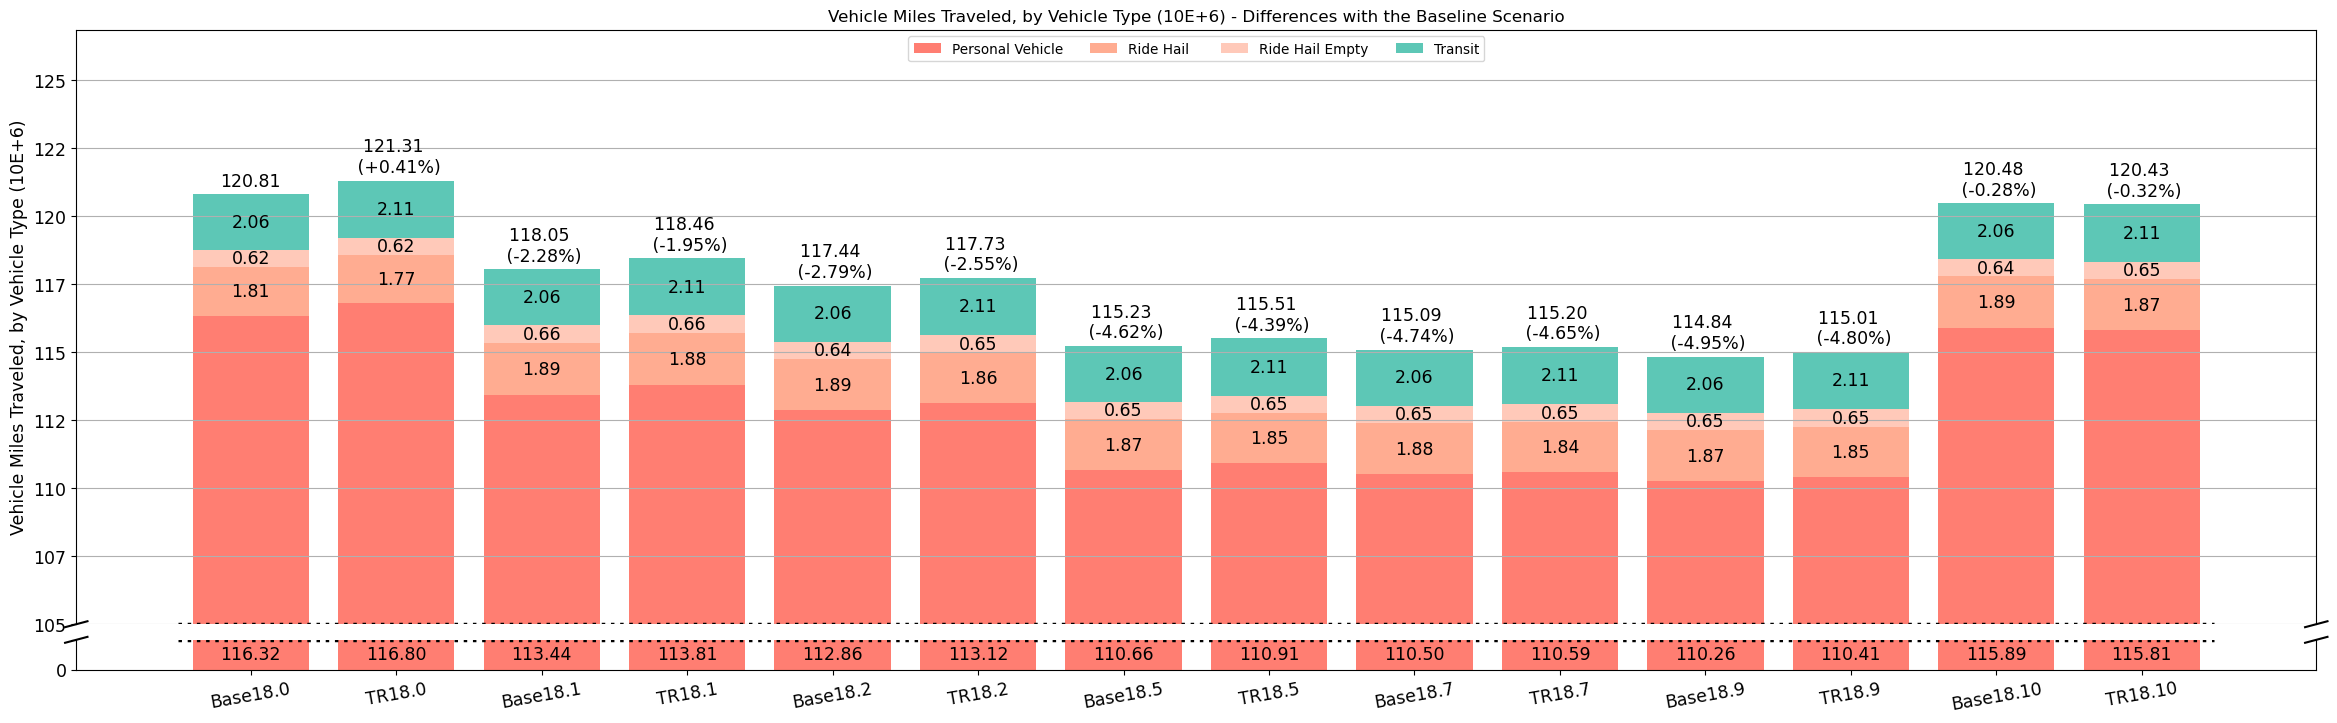

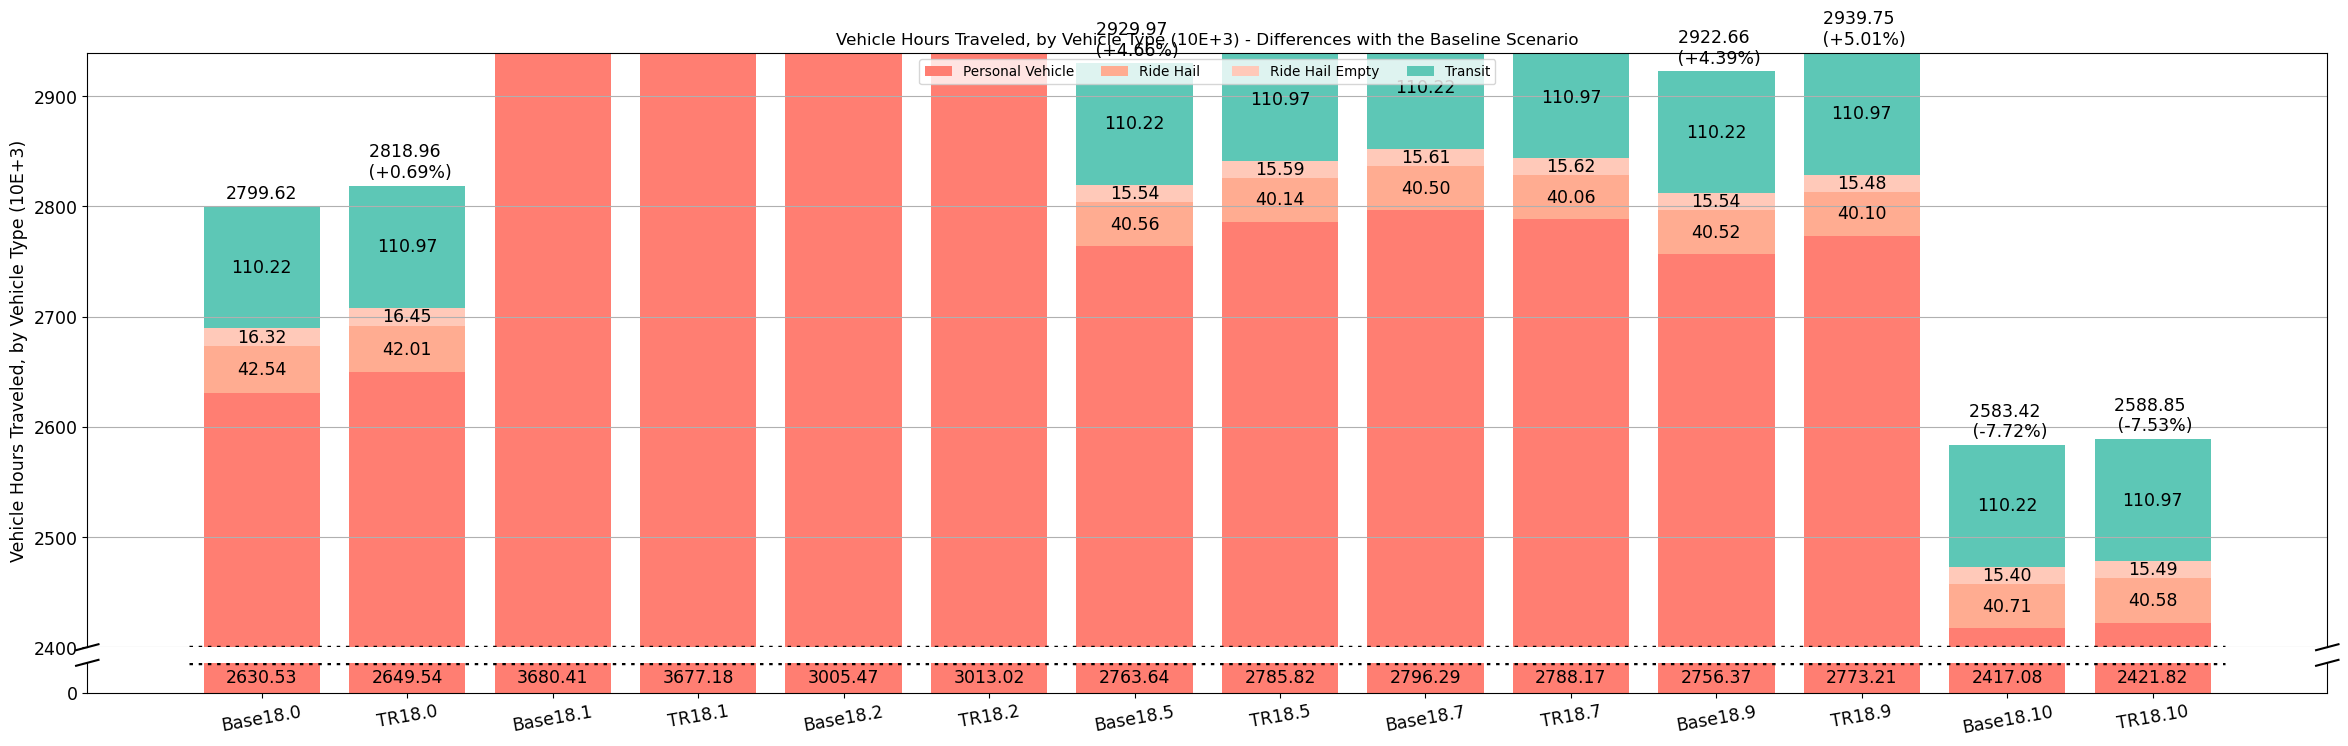

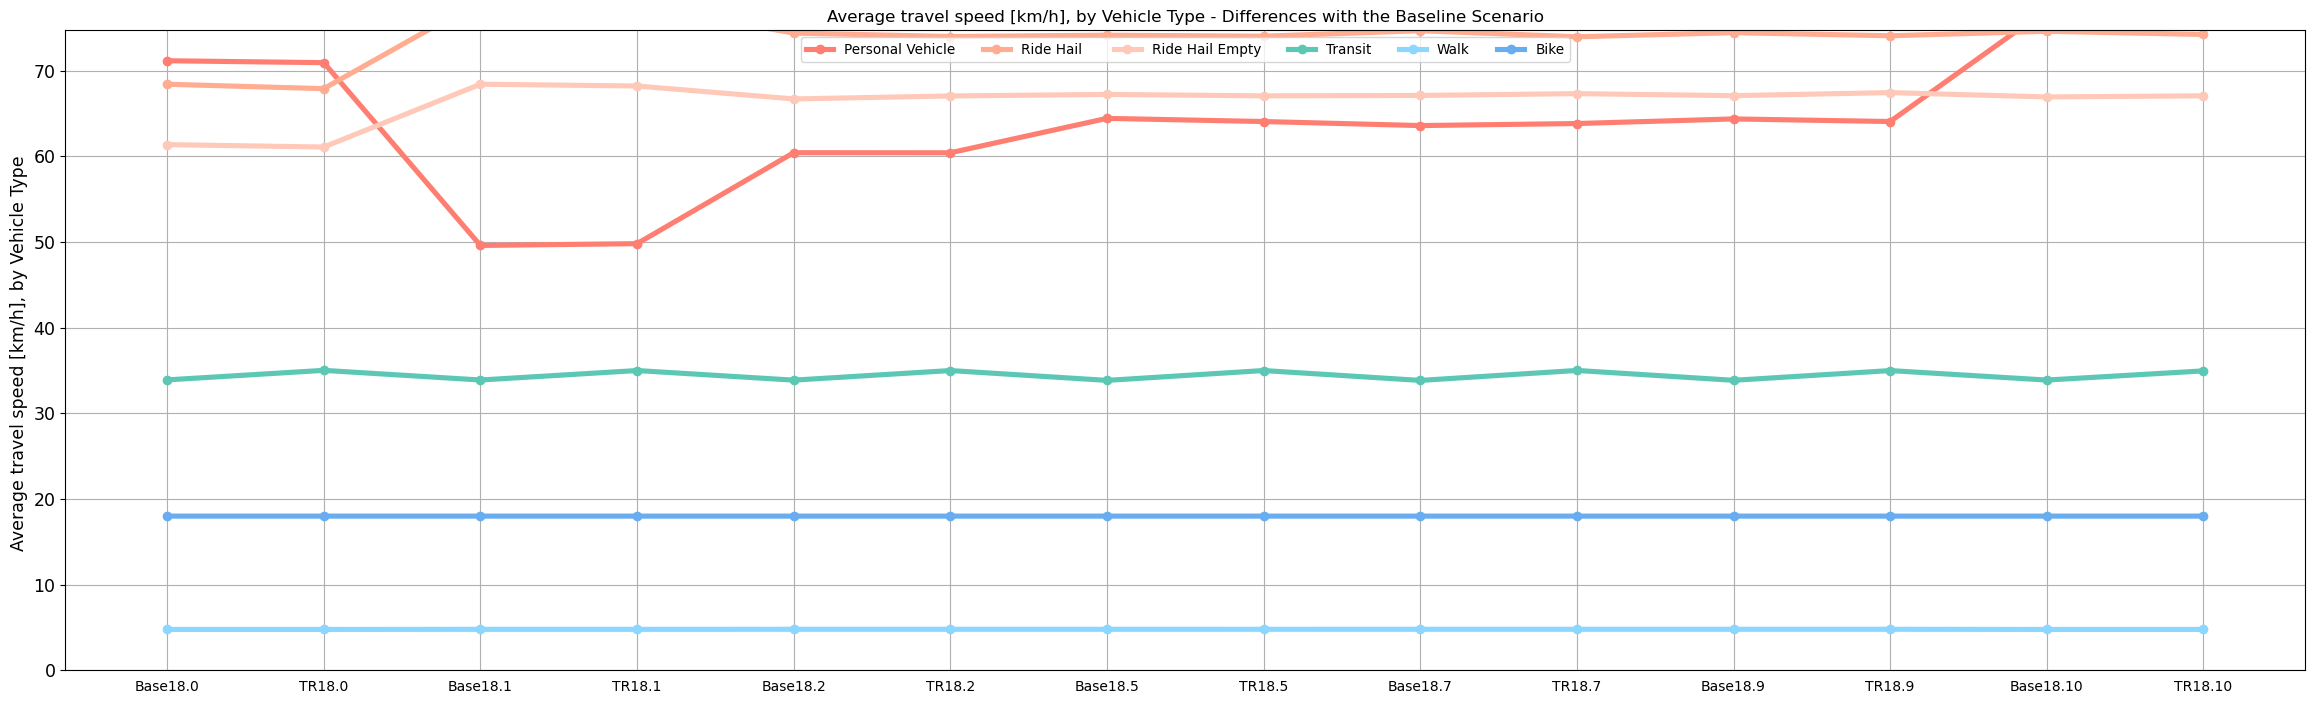

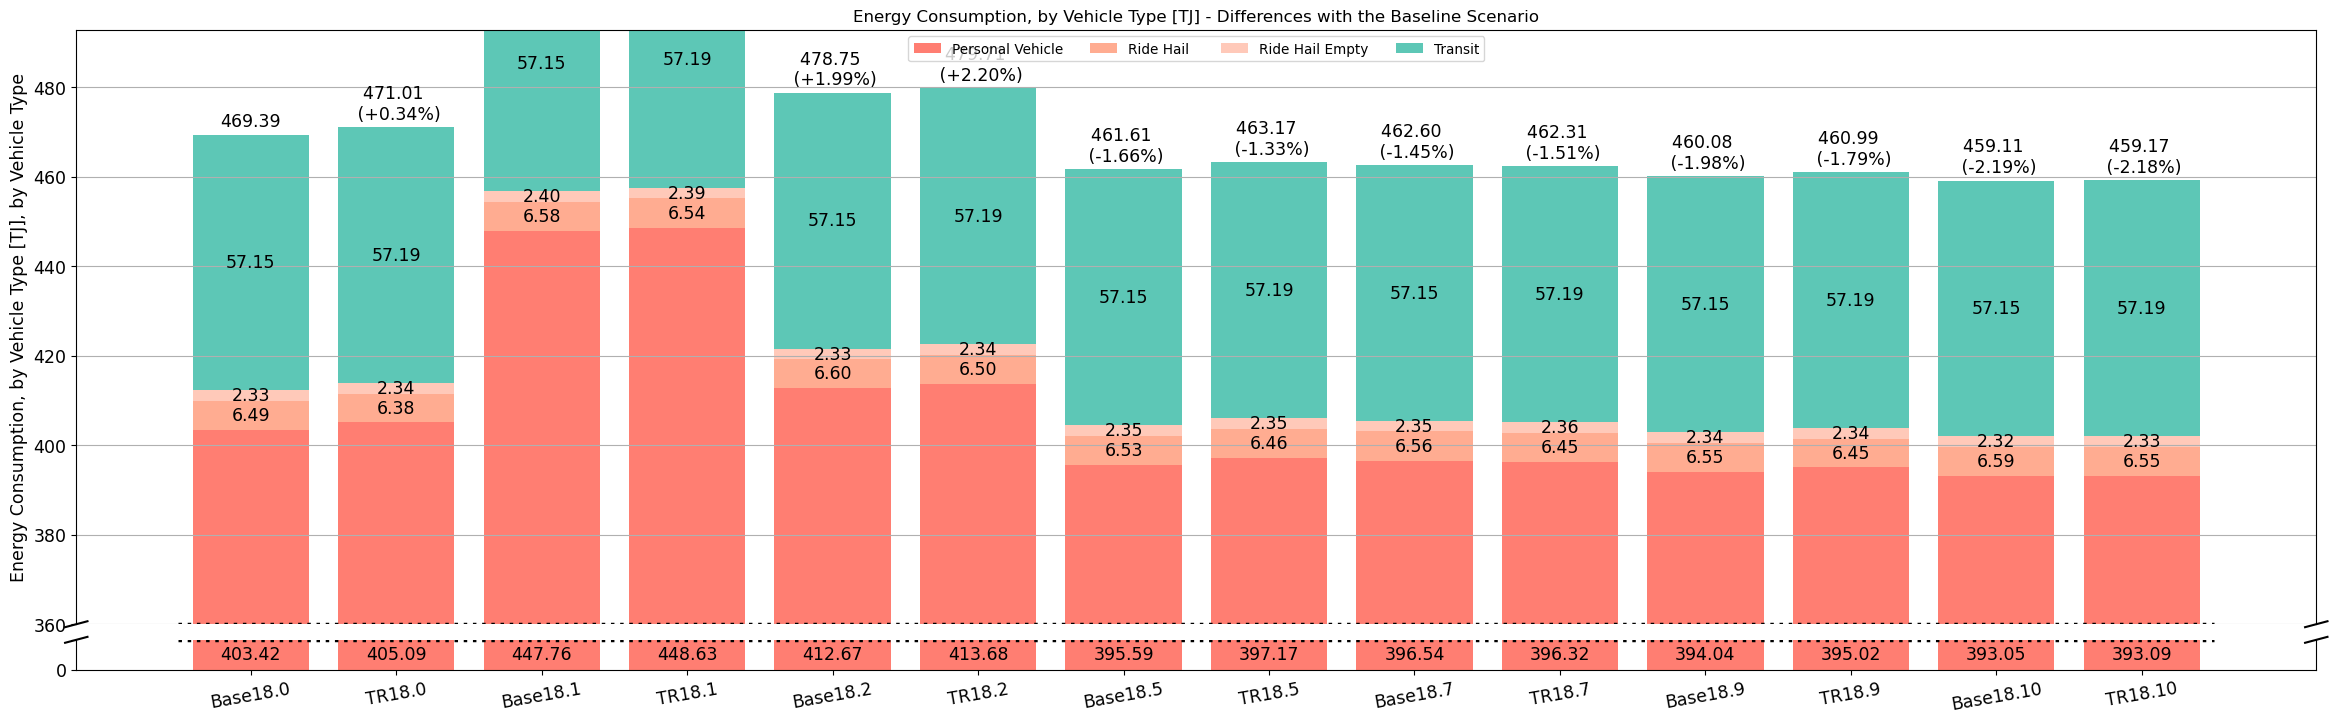

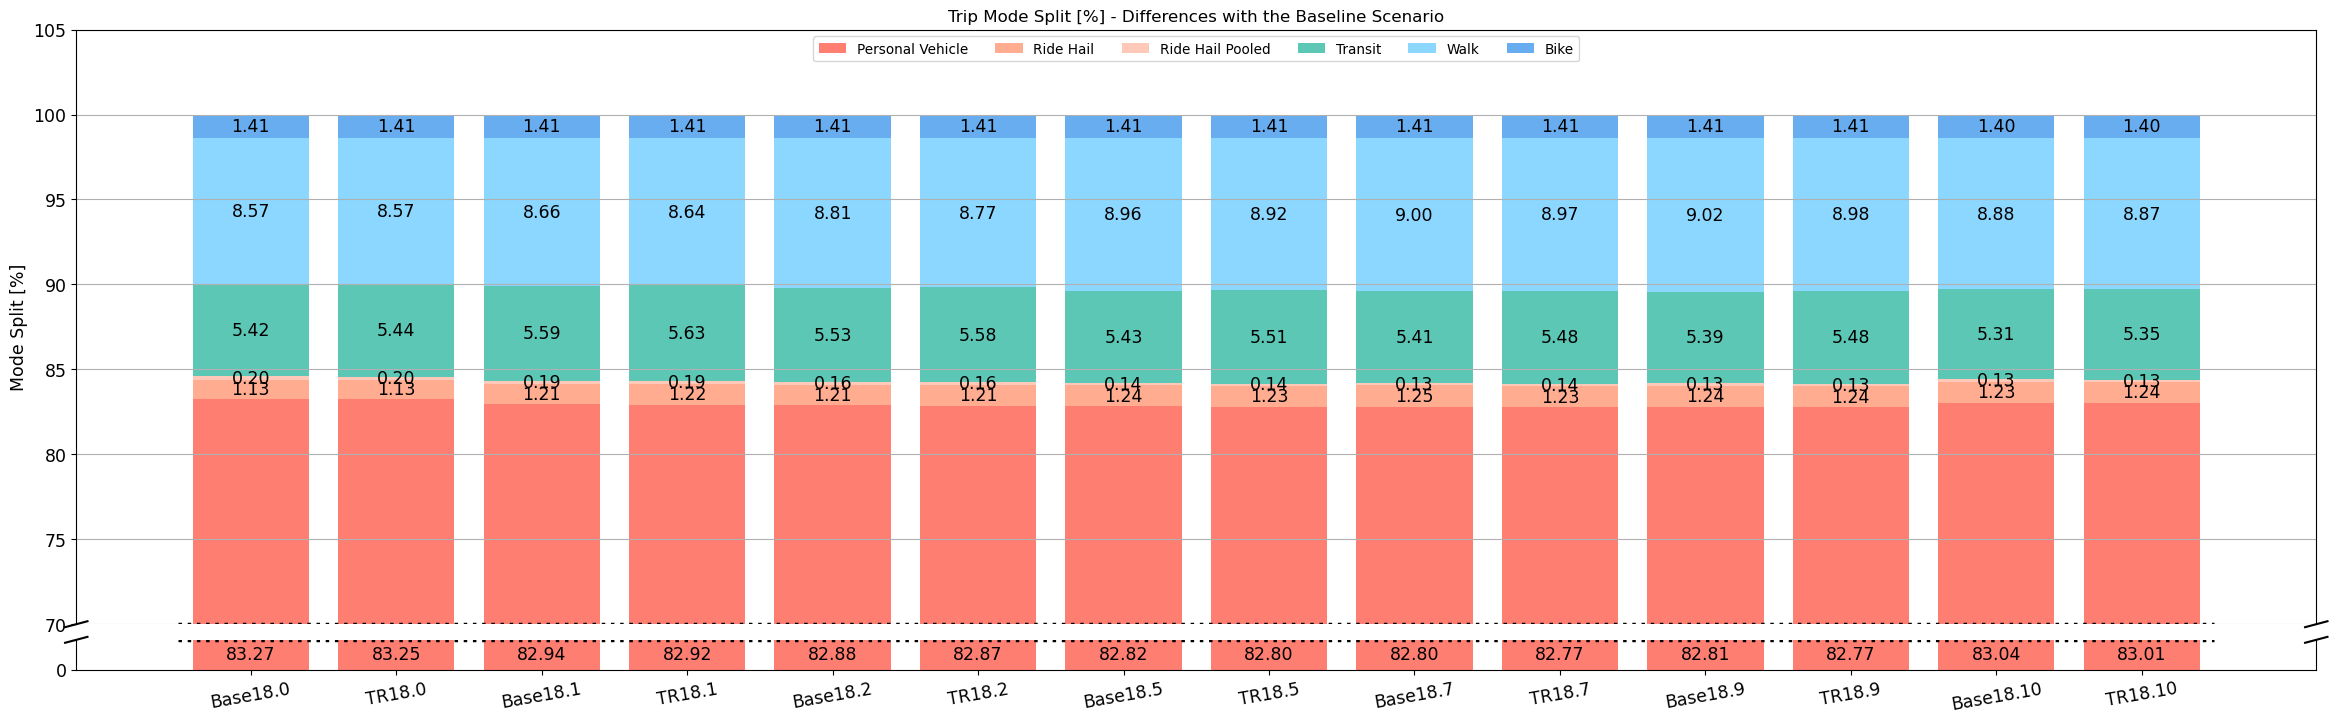

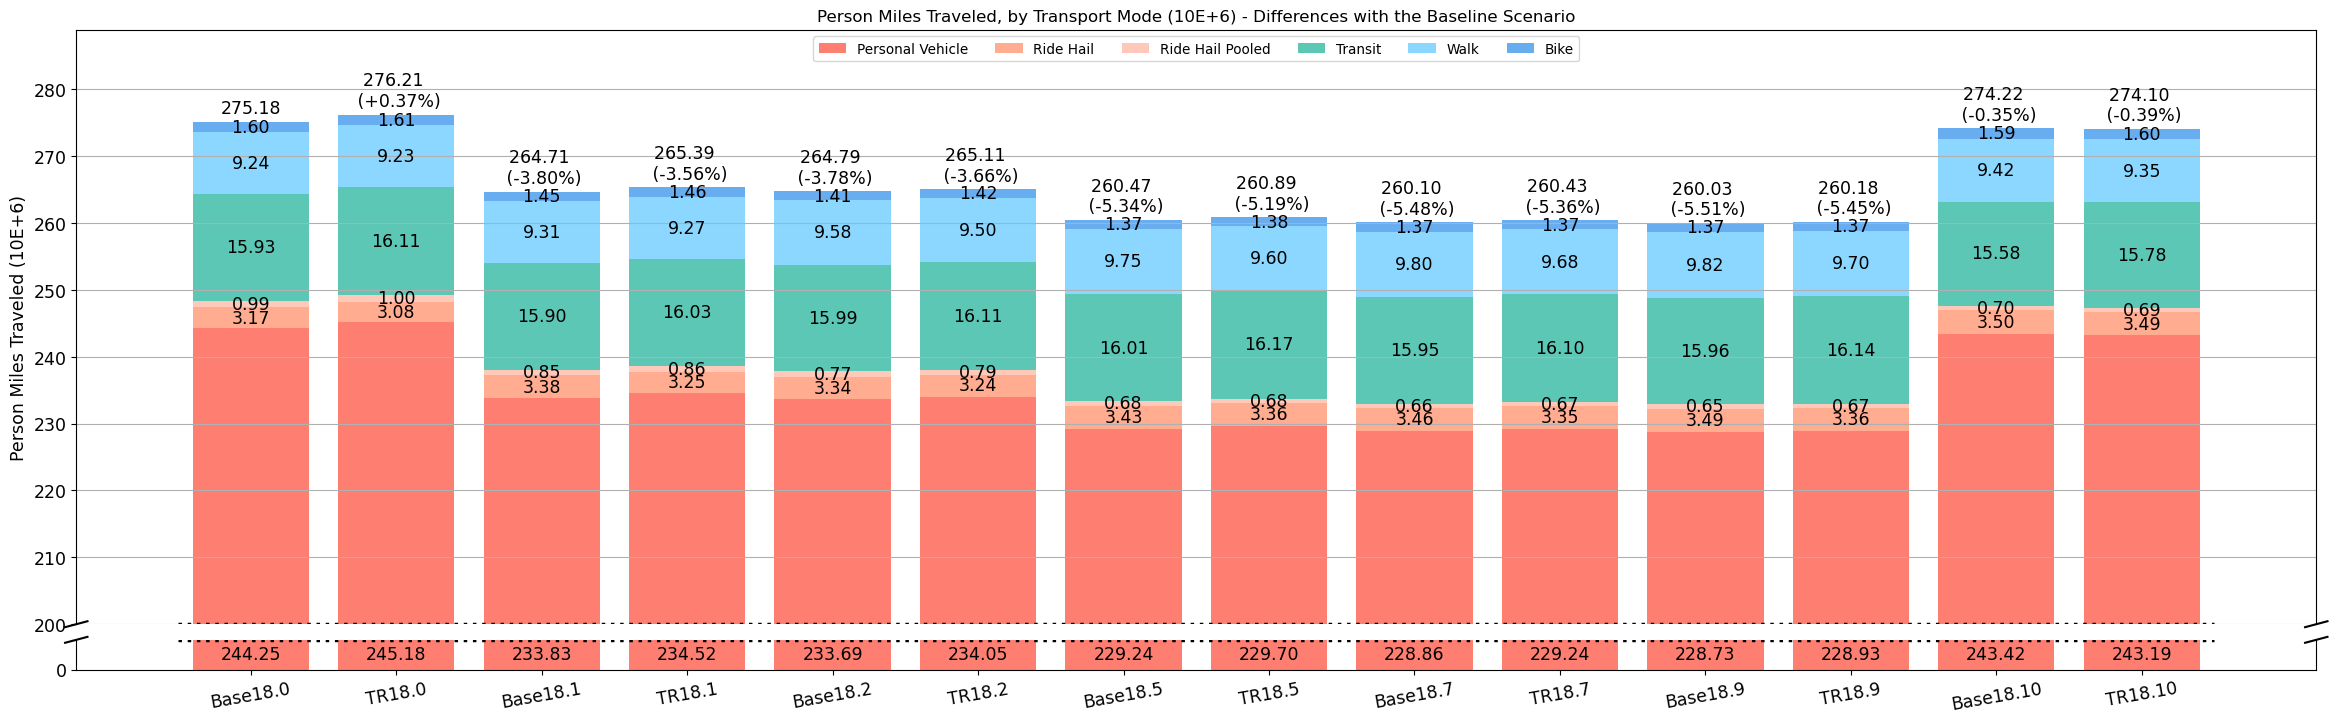

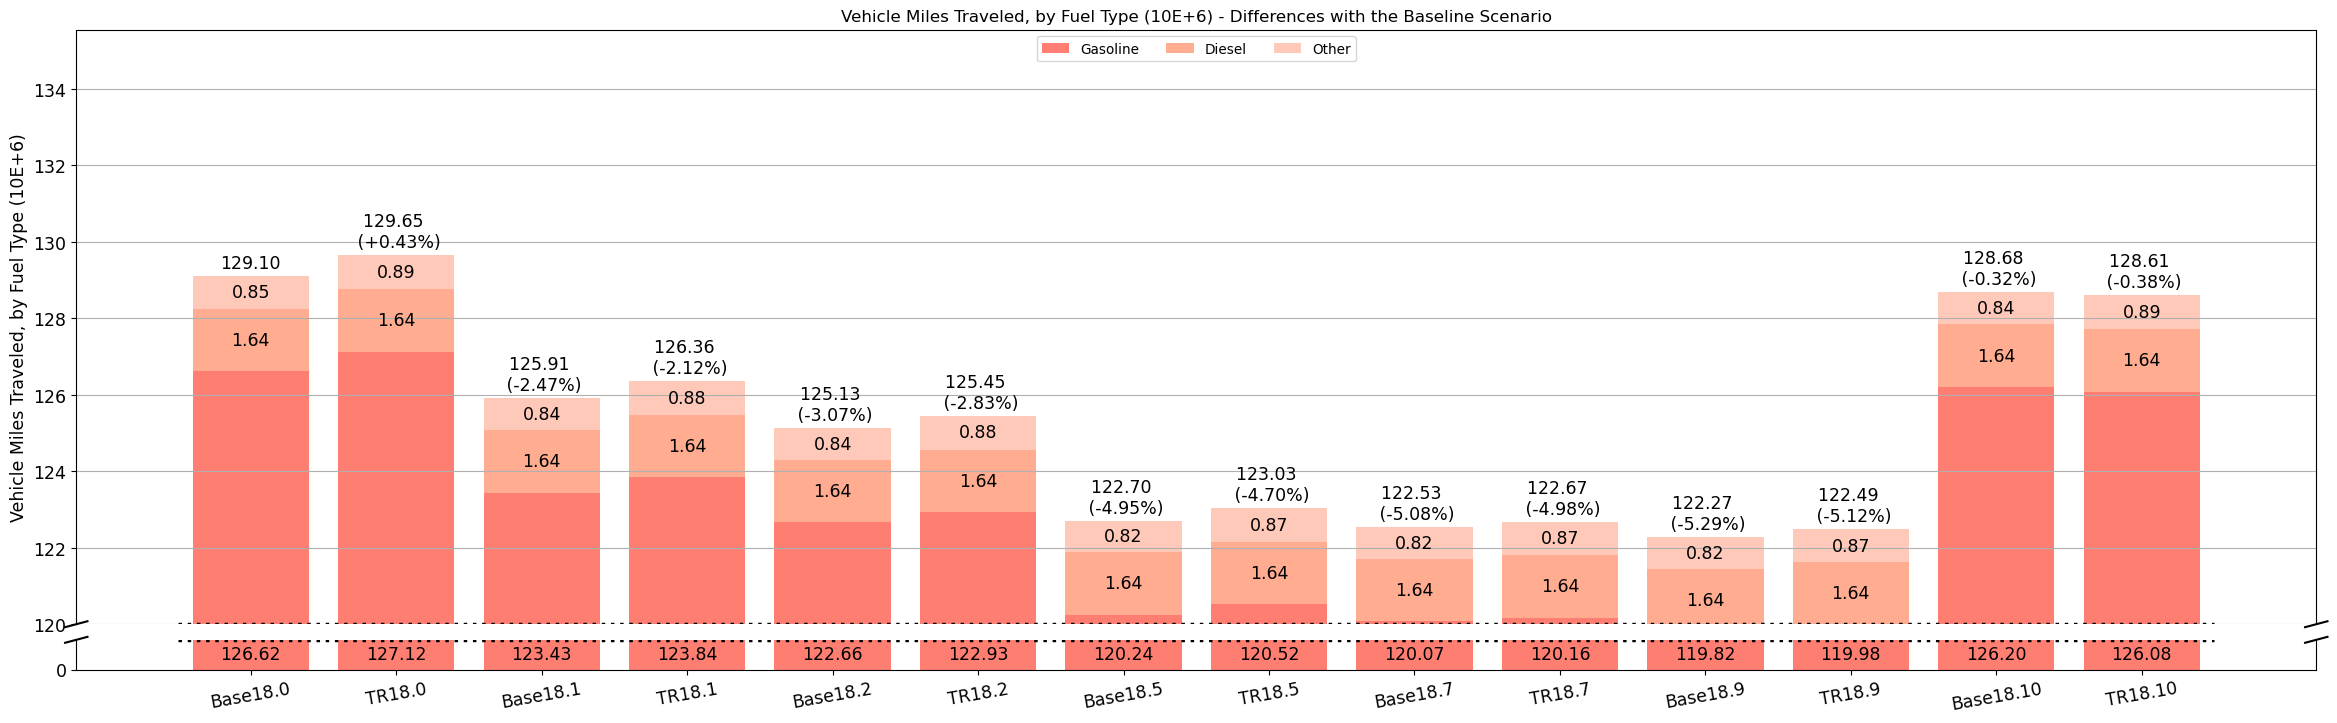

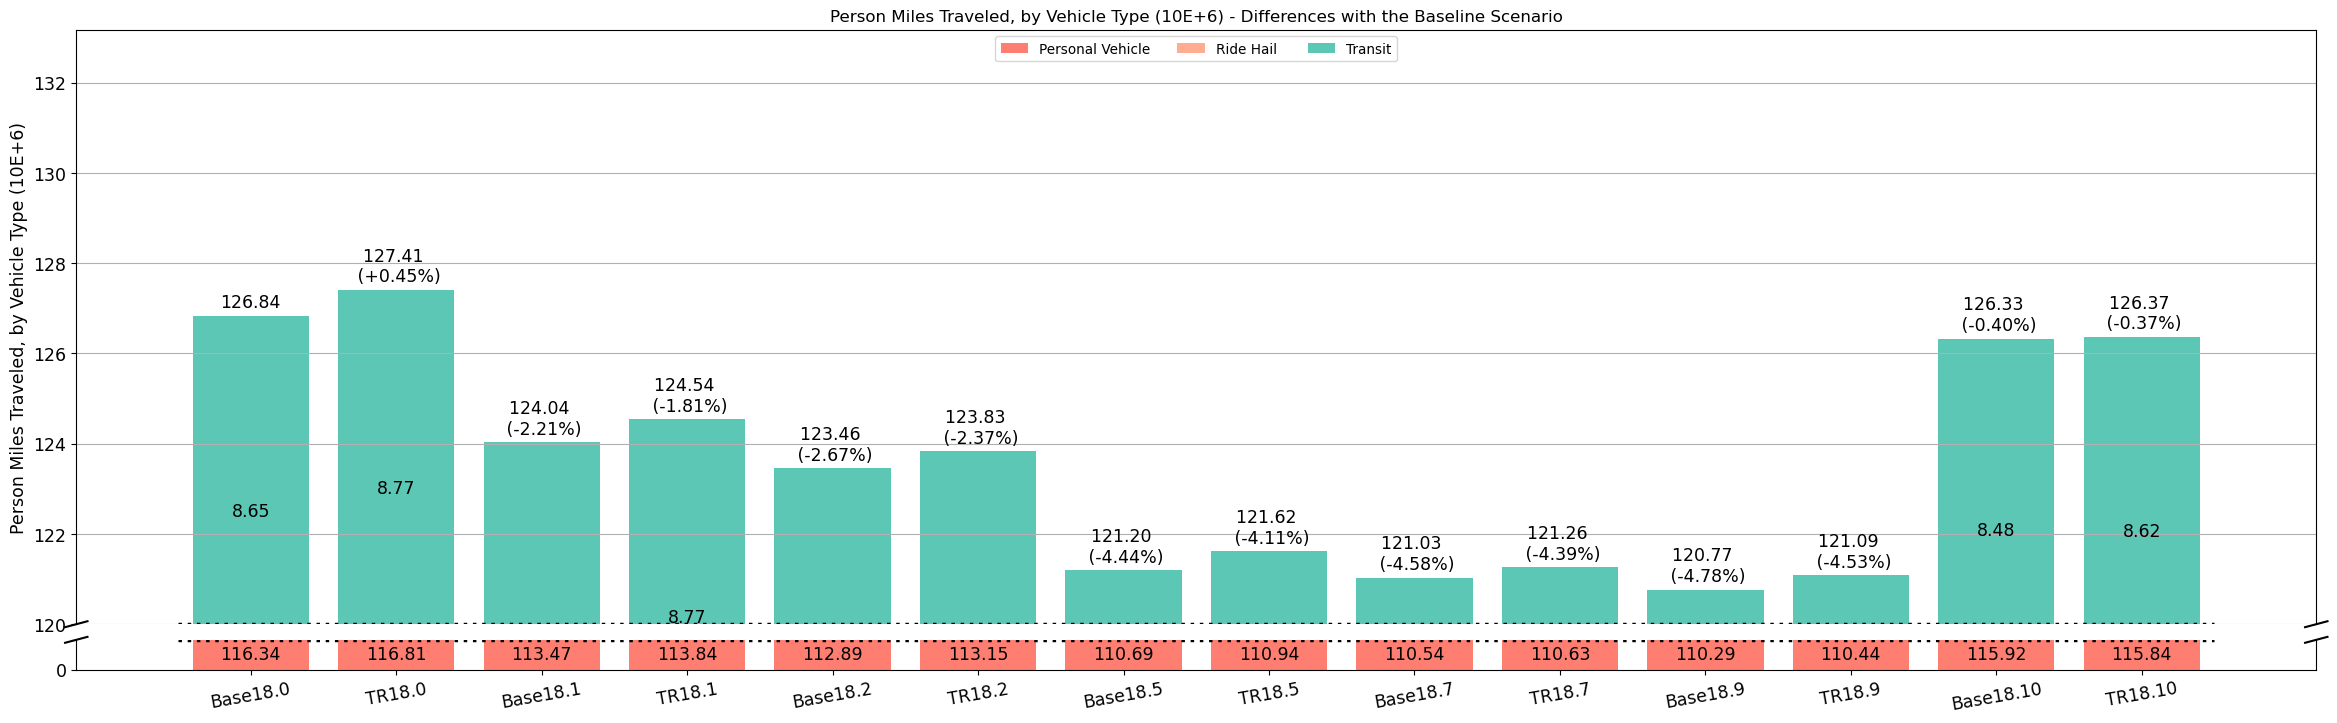

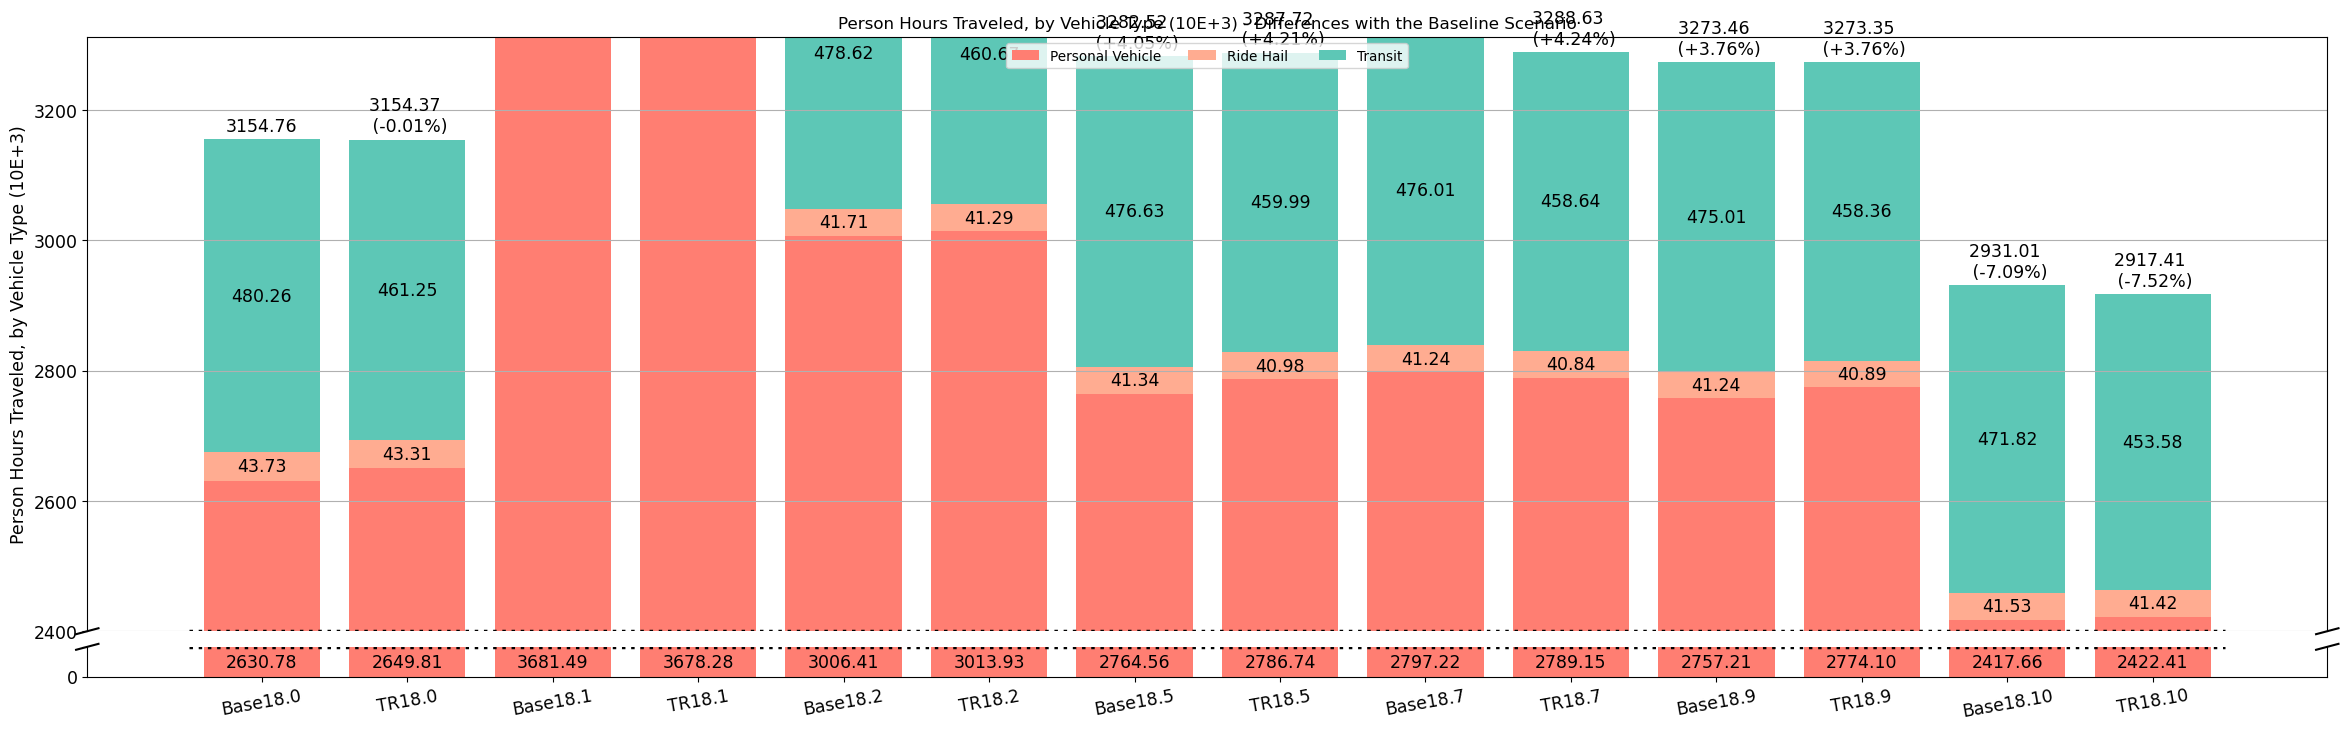

In [16]:
ST = pd.read_csv('outputs/ST-smart2_32.csv', index_col = 0).fillna(0)
# plot_and_save_figures('outputs/', ST, ['Baseline_20221224','RH Price 0%','RH Price 12.5%','RH Price 25%','RH Price 50%','RH Price 175%','RH Price 300%','RH Price 500%','RH Price 800%',
#                                       'RH Fleet 12.5%','RH Fleet 25%','RH Fleet 50%','RH Fleet 200%','RH Fleet 400%','RH Fleet 1000%','RH Fleet 2750%'])
Scale = 0.3
is_WC = False
# plot_and_save_figures('outputs/', ST, ['Base 20221224','TR 2018','TR 2019','TR 2020','TR 2021','TR 2022','TR 2023','TR 2024','TR 2018-1','TR 2018-2','TR 2018-3','TR 2018-4','TR 2018-5','TR 2018-6','TR 2018-7','TR 2018-8','TR 2018-9','TR 2018-10','TR 2018-11','TR 2018-12'])
# plot_and_save_figures('outputs/', ST, ['Baseline',
                                       # '1Fl 1Pr 1Flz','5Fl 1Pr 1Flz','5Fl 1Pr 1.6Flz','5Fl 1Pr 2Flz','5Fl 1Pr 4Flz','5Fl 1Pr 10Flz',
                                       # '2Fl 1Pr 1.6Flz','2Fl 1Pr 2Flz','2Fl 1Pr 4Flz','2Fl 1Pr 10Flz',
                                       # '2Fl .47Pr 1Flz','5Fl .47Pr 1Flz','5Fl .47Pr 1.6Flz','5Fl .47Pr 2Flz','5Fl .47Pr 4Flz','5Fl .47Pr 10Flz',
                                       # '2Fl .27Pr 1Flz','5Fl .27Pr 1Flz','5Fl .27Pr 1.6Flz','5Fl .27Pr 2Flz','5Fl .27Pr 4Flz','5Fl .27Pr 10Flz',
                                       # '2Fl .125Pr 1Flz','5Fl .125Pr 1Flz','5Fl .125Pr 1.6Flz','5Fl .125Pr 2Flz','5Fl .125Pr 4Flz','5Fl .125Pr 10Flz',
                                       # '2Fl .0625Pr 1Flz','5Fl .0625Pr 1Flz','5Fl .0625Pr 1.6Flz','5Fl .0625Pr 2Flz','5Fl .0625Pr 4Flz','5Fl .0625Pr 10Flz',
                                       # '1Fl MixPr 1Flz','2Fl MixPr 1Flz','5Fl MixPr 1Flz','5Fl MixPr 1.6Flz','5Fl MixPr 2Flz','5Fl MixPr 4Flz','5Fl MixPr 10Flz'
                                      # ])
        
mins = [350, 8000, 0, 1200, 70, 60, 400, 400, 8000]
mults = [1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05,  1.05,1.05,]
plot_and_save_figures('outputs/', ST, #'BS 2018-1','TR 2018-1','BS 2018-2','TR 2018-2','BS 2018-3','TR 2018-3','BS 2018-4','TR 2018-4','BS 2018-5','TR 2018-5',
                                        list(ST.keys()[:-1]), mins, mults)
                                      

